### Visualizar en mapa las diferentes tiendas que tienen productos en especifico y los locales en renta

In [1]:
import ETL as etl  
import pandas as pd

In [2]:
nombre_archivo = './datasets/09-2023_02.csv'
nombre_productos = ['JITOMATE','AGUACATE','LECHUGA','PAPA']
presentaciones = ['1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE','1 KG. HASS','PZA. ROMANA','1 KG. ALFA/BLANCA']
fecha = '2023-09-28'

In [3]:
df = etl.ETL_ARCHIVO(nombre_archivo,nombre_productos,presentaciones,fecha)
df2 = pd.read_csv('./datasets/inmuebles24Corregido.csv', sep=',' , encoding='utf-8')

In [4]:
df.head(5)

,NOMBRECOMERCIAL,PRECIO,FECHAREGISTRO,PRESENTACIÓN,MARCA,LATITUD,LONGITUD,PRODUCTO
77176,BODEGA AURRERA EXPRESS SUCURSAL AZCAPOTZALCO,32.9,2023-09-28,1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE,S/M,19.482528,-99.184364,JITOMATE
77662,MERCADO SORIANA SUCURSAL AZCAPOTZALCO,30.9,2023-09-28,1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE,S/M,19.478250,-99.187038,JITOMATE
78592,WALMART SUCURSAL CUITLAHUAC,32.9,2023-09-28,1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE,S/M,19.471594,-99.164840,JITOMATE
110976,BODEGA AURRERA SUCURSAL CANTIL,27.9,2023-09-28,1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE,S/M,19.330481,-99.154328,JITOMATE
111872,LACOMER SUCURSAL MIGUEL ANGEL DE QUEVEDO,38.9,2023-09-28,1 KG. SALADETTE/ HUAJE O TOMATE SALADETTE/ HUAJE,S/M,19.345444,-99.172181,JITOMATE


In [5]:
df2.head(5)

,precio,ubicacion,tamanio,latitud,longitud
0,8000,"BOLAÑOS, Felipe Pescador, Cuauhtémoc",30,19.454,-99.12
1,16000,"Huitzilopochtli Lte 14 Mz 19, Adolfo Ruiz Co...",35,19.320,-99.15
2,9000,"Lucerna 65, Juárez, Cuauhtémoc",8,19.430,-99.15
3,18000,"Montecito 38, Nápoles, Benito Juárez",40,19.394,-99.17
4,7500,"Petén, Narvarte Oriente, Benito Juárez",12,19.387,-99.15


In [6]:
df = df.groupby(['PRODUCTO','NOMBRECOMERCIAL','LATITUD','LONGITUD']).agg({'PRECIO':'mean'}).reset_index()

In [7]:
# Contar la cantidad de productos distintos que tiene cada tienda
df['COUNT'] = df.groupby('NOMBRECOMERCIAL')['PRODUCTO'].transform('nunique')

# Filtrar las tiendas que tienen todos los productos deseados
tiendas_con_todos_los_productos = df[(df['COUNT'] == len(nombre_productos))]

# Eliminar la columna de conteo
tiendas_con_todos_los_productos = tiendas_con_todos_los_productos.drop(columns=['COUNT'])

# Agrupar por tienda y calcular la suma de precios
total_precios_por_tienda = tiendas_con_todos_los_productos.groupby('NOMBRECOMERCIAL')['PRECIO'].sum()

# Mantener las coordenadas de las tiendas
coordenadas_tienda = tiendas_con_todos_los_productos.groupby('NOMBRECOMERCIAL')[['LATITUD', 'LONGITUD']].first()

# Combinar los resultados en un nuevo DataFrame
resultado_final = pd.concat([total_precios_por_tienda, coordenadas_tienda], axis=1)

# Ordenar las tiendas por precio total de menor a mayor
resultado_final = resultado_final.sort_values(by='PRECIO')



In [8]:
# Reiniciar el índice del DataFrame
resultado_final.reset_index(inplace=True)

# Ordenar las tiendas por precio total de menor a mayor
resultado_final = resultado_final.sort_values(by='PRECIO')

# Mostrar los resultados
(resultado_final)

,NOMBRECOMERCIAL,PRECIO,LATITUD,LONGITUD
0,CHEDRAUI SUCURSAL ANFORA,122.40,19.437353,-99.110088
1,U.N.A.M. SUCURSAL 02 CD UNIVERSITARIA,127.73,19.322043,-99.176224
2,MEGA SORIANA SUCURSAL ASTURIAS,137.20,19.407812,-99.132654
3,SORIANA HIPER SUCURSAL CONSULADO (418),141.60,19.449572,-99.100376
4,BODEGA AURRERA SUCURSAL LA VIGA,143.70,19.414749,-99.127874
5,BODEGA AURRERA SUCURSAL CANTIL,147.70,19.330481,-99.154328
6,BODEGA AURRERA EXPRESS SUCURSAL LOS GALLOS,149.70,19.455788,-99.162735
7,BODEGA AURRERA EXPRESS SUCURSAL AZCAPOTZALCO,153.70,19.482528,-99.184364
8,WALMART SUCURSAL PORTAL CENTRO,153.70,19.419472,-99.130269
9,WALMART SUCURSAL BALBUENA,154.70,19.418067,-99.105639


In [10]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Carga el archivo GeoJSON
gdf = gpd.read_file('./geojson/alcaldias.json')


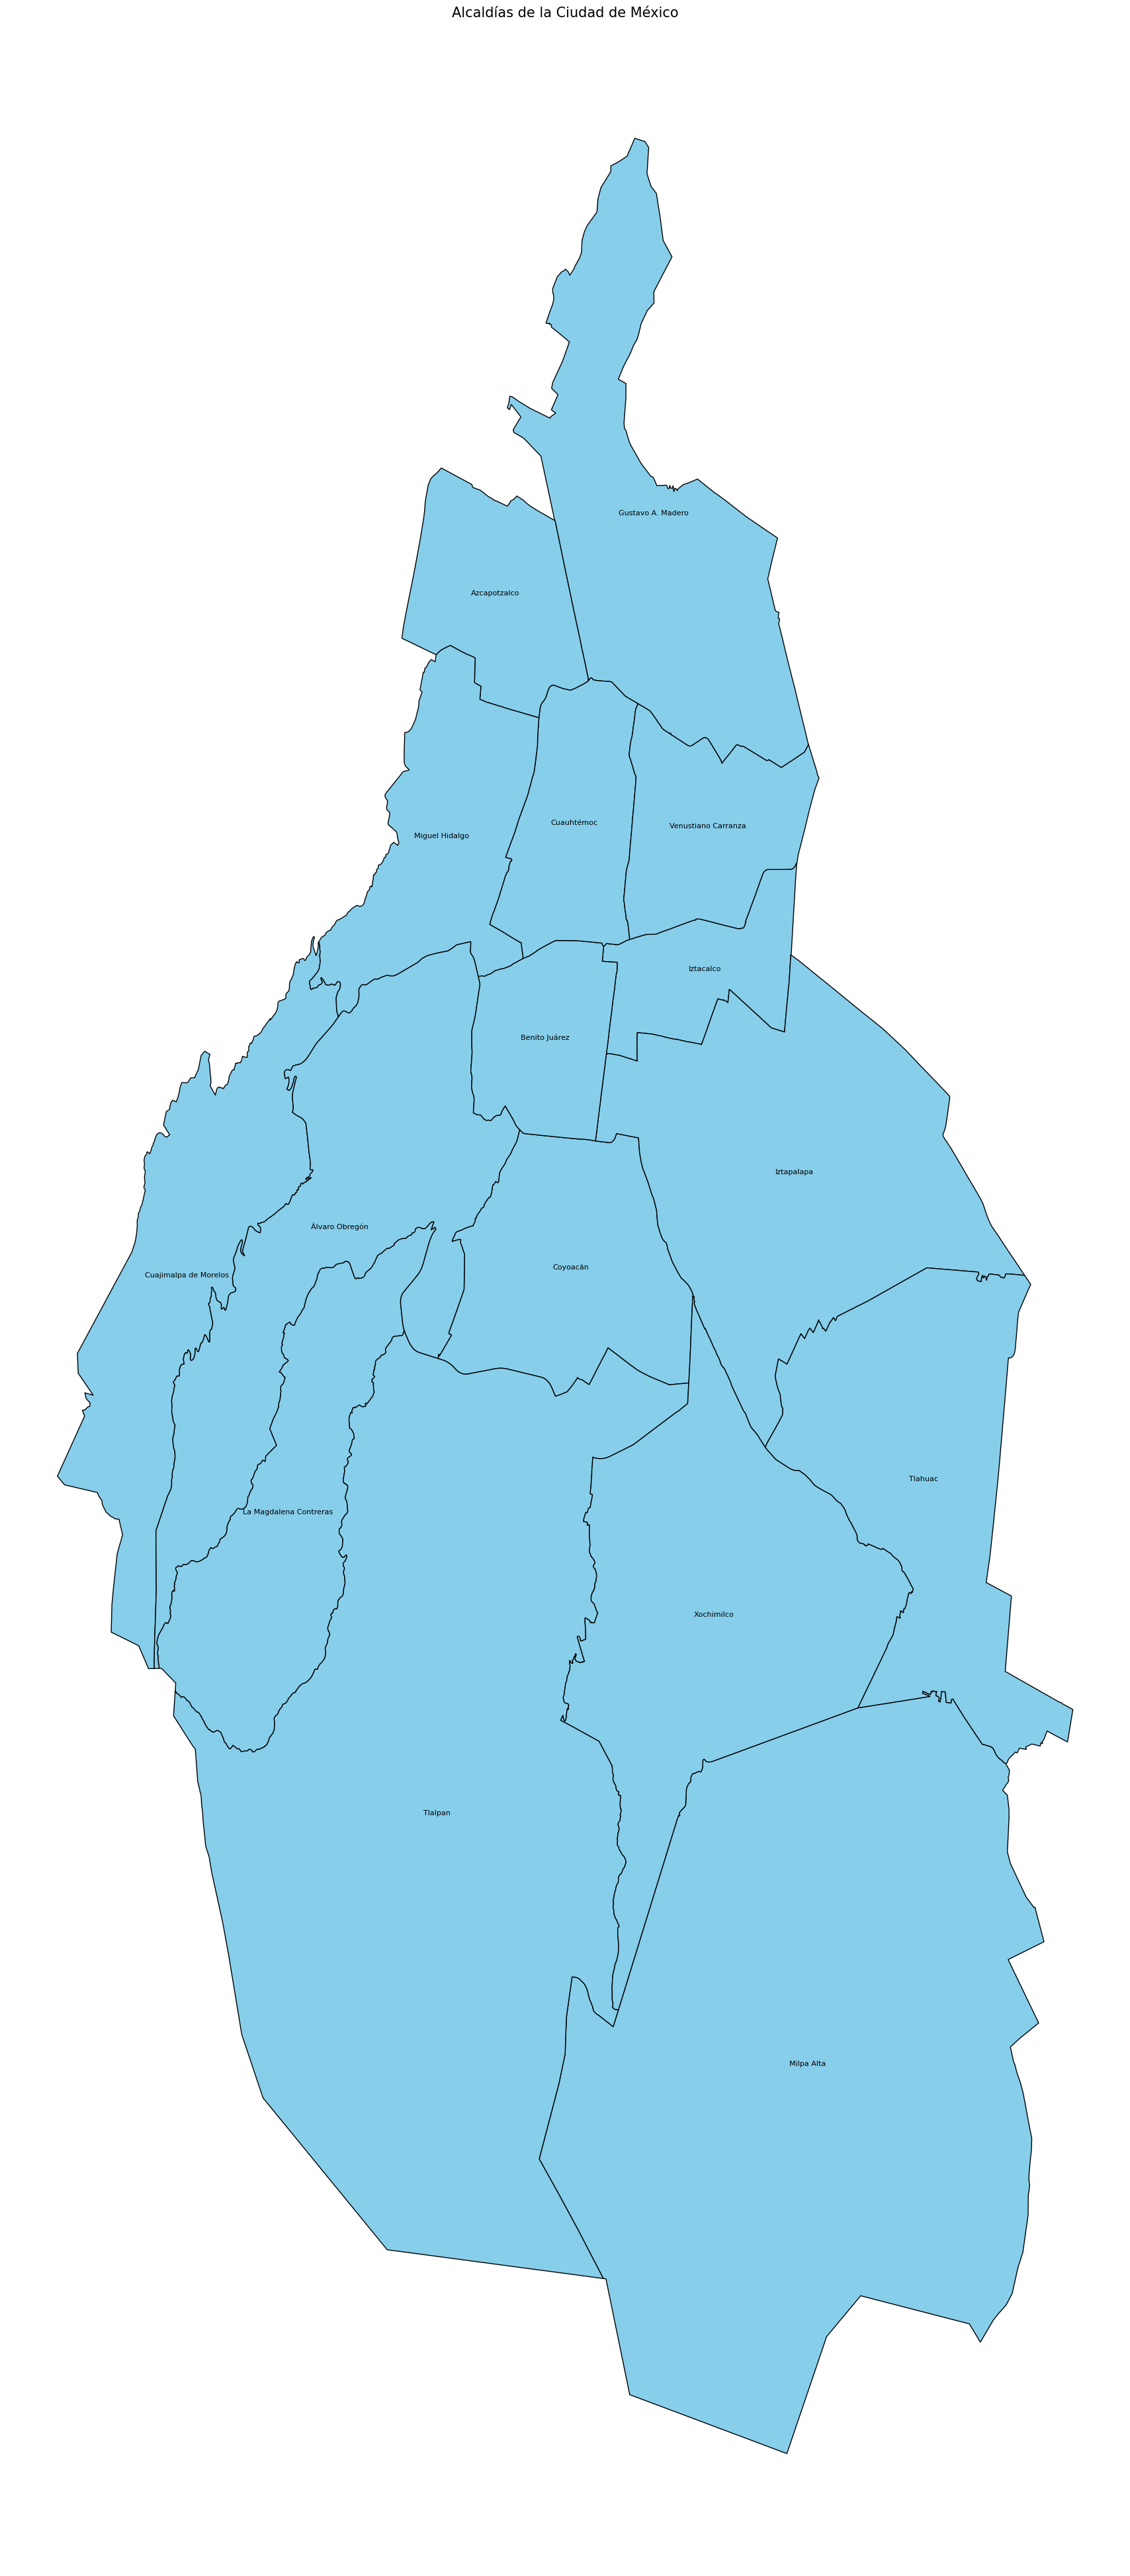

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(50, 50))
gdf.plot(ax=ax, color='skyblue', edgecolor='black')
for idx, row in gdf.iterrows():
    plt.annotate(text=row['NOMBRE'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')
ax.set_title('Alcaldías de la Ciudad de México', fontsize=15)
ax.set_axis_off()
plt.show()


In [12]:
# Datos adicionales proporcionados para incorporar al GeoJSON
data_to_add = {
    "Álvaro Obregón": {"Población": 759137, "Superficie": 96.17, "Densidad": 7894, "Código Postal": "01000 - 01999"},
    "Azcapotzalco": {"Población": 432205, "Superficie": 33.66, "Densidad": 12840, "Código Postal": "02000 - 02999"},
    "Benito Juárez": {"Población": 434153, "Superficie": 26.63, "Densidad": 16303, "Código Postal": "03000 - 03999"},
    "Coyoacán": {"Población": 614447, "Superficie": 54.4, "Densidad": 11295, "Código Postal": "04000 - 04999"},
    "Cuajimalpa de Morelos": {"Población": 217686, "Superficie": 80.95, "Densidad": 2689, "Código Postal": "05000 - 05999"},
    "Cuauhtémoc": {"Población": 545884, "Superficie": 32.4, "Densidad": 16848, "Código Postal": "06000 - 06999"},
    "Gustavo A. Madero": {"Población": 1173351, "Superficie": 94.07, "Densidad": 12473, "Código Postal": "07000 - 07999"},
    "Iztacalco": {"Población": 404695, "Superficie": 23.3, "Densidad": 17369, "Código Postal": "08000 - 08999"},
    "Iztapalapa": {"Población": 1835486, "Superficie": 117, "Densidad": 15687, "Código Postal": "09000 - 09999"},
    "Magdalena Contreras": {"Población": 247622, "Superficie": 74.58, "Densidad": 3320, "Código Postal": "10000 - 10999"},
    "Miguel Hidalgo": {"Población": 414470, "Superficie": 46.99, "Densidad": 8820, "Código Postal": "11000 - 11999"},
    "Milpa Alta": {"Población": 152685, "Superficie": 228.41, "Densidad": 668, "Código Postal": "12000 - 12999"},
    "Tlahuac": {"Población": 392313, "Superficie": 85.34, "Densidad": 4597, "Código Postal": "13000 - 13999"},
    "Tlalpan": {"Población": 699928, "Superficie": 312, "Densidad": 2243, "Código Postal": "14000 - 14999"},
    "Venustiano Carranza": {"Población": 443704, "Superficie": 33.4, "Densidad": 13284, "Código Postal": "15000 - 15999"},
    "Xochimilco": {"Población": 442178, "Superficie": 122, "Densidad": 3624, "Código Postal": "16000 - 16999"}
}

# Añadiendo los datos al GeoDataFrame
for alcaldia, datos in data_to_add.items():
    # Encuentra la fila correspondiente a la alcaldía y actualiza los datos
    gdf.loc[gdf['NOMBRE'] == alcaldia, 'Población'] = datos['Población']
    gdf.loc[gdf['NOMBRE'] == alcaldia, 'Superficie'] = datos['Superficie']
    gdf.loc[gdf['NOMBRE'] == alcaldia, 'Densidad'] = datos['Densidad']
    gdf.loc[gdf['NOMBRE'] == alcaldia, 'Código Postal'] = datos['Código Postal']

# Verificando los cambios en el GeoDataFrame
gdf.head()


,CVEGEO,NOM_ENT,NOMBRE,POB1,geometry,Población,Superficie,Densidad,Código Postal
0,09002,Distrito Federal,Azcapotzalco,414711,"POLYGON ((480871.10315 2156990.62231, 480872.7...",432205.0,33.66,12840.0,02000 - 02999
1,09003,Distrito Federal,Coyoacán,620416,"POLYGON ((484929.18459 2140362.45245, 484992.8...",614447.0,54.40,11295.0,04000 - 04999
2,09004,Distrito Federal,Cuajimalpa de Morelos,186391,"POLYGON ((472976.73774 2145231.64813, 473018.2...",217686.0,80.95,2689.0,05000 - 05999
3,09005,Distrito Federal,Gustavo A. Madero,1185772,"POLYGON ((487636.74019 2166181.55334, 487561.8...",1173351.0,94.07,12473.0,07000 - 07999
4,09006,Distrito Federal,Iztacalco,384326,"POLYGON ((494143.44235 2147538.45030, 494138.2...",404695.0,23.30,17369.0,08000 - 08999


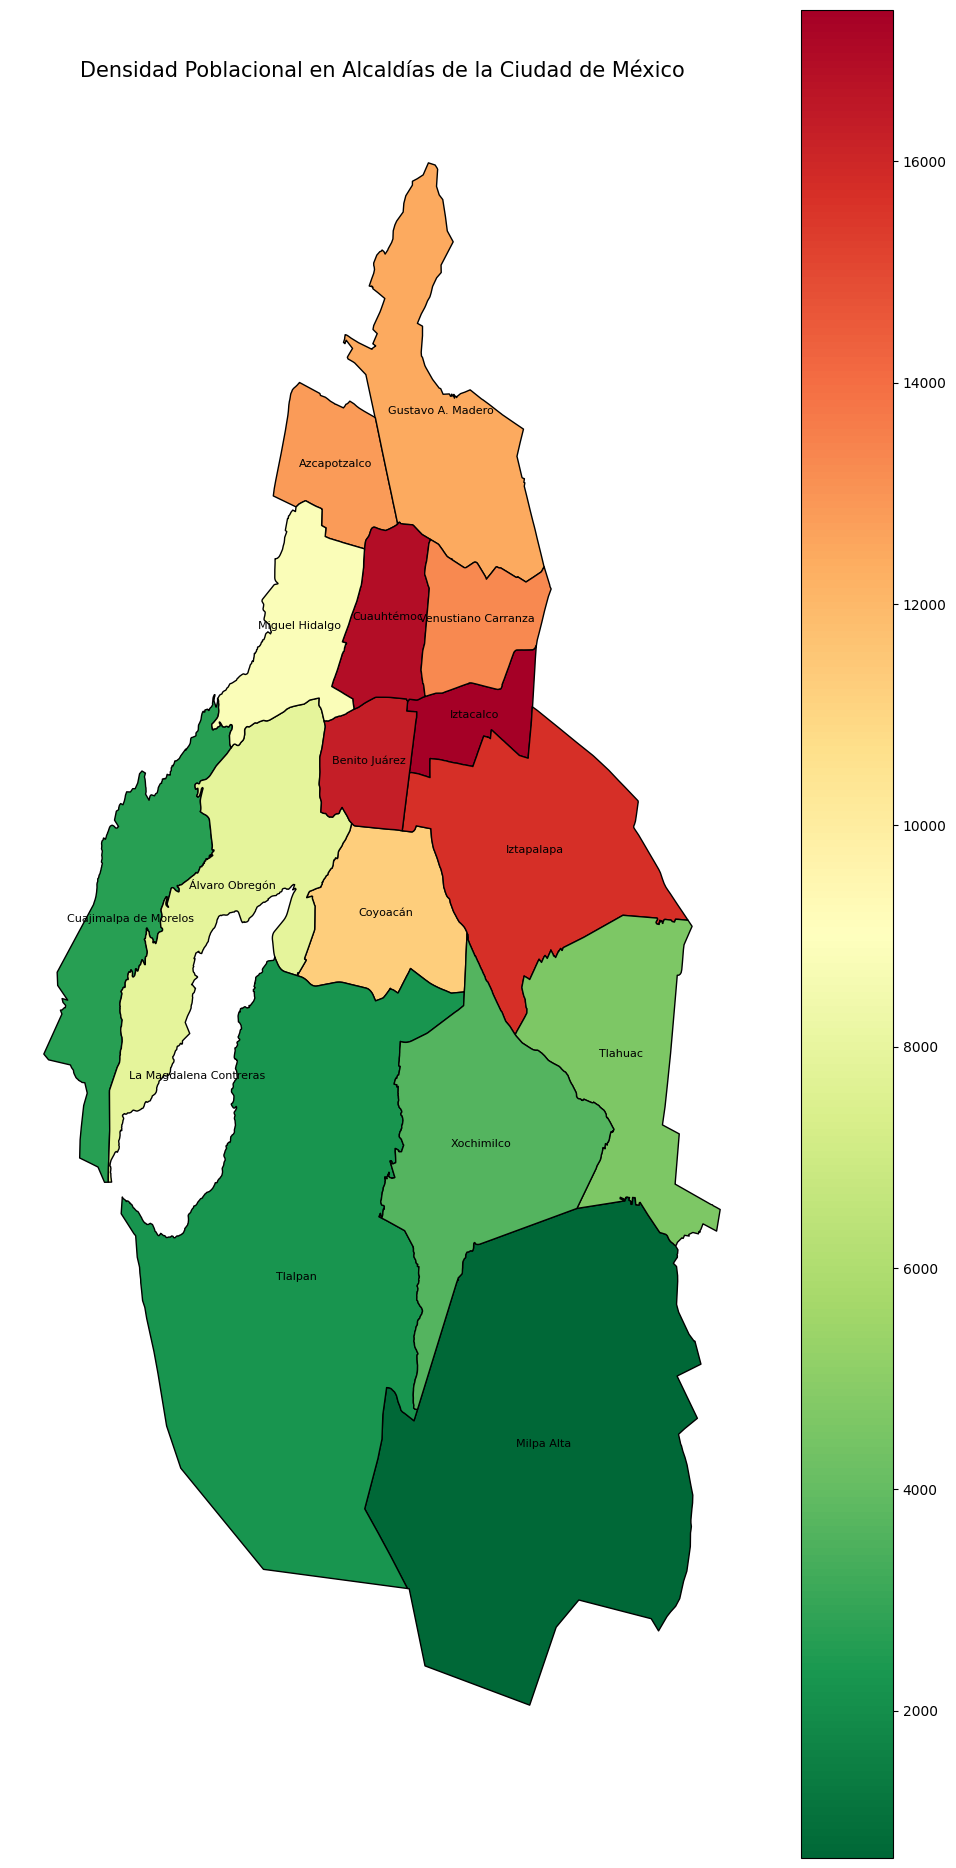

In [13]:
# Configurando la visualización del mapa con un gradiente de color basado en la densidad poblacional
fig, ax = plt.subplots(1, 1, figsize=(12, 24))
gdf.plot(ax=ax, column='Densidad', cmap='RdYlGn_r', legend=True, edgecolor='black')

# Añadiendo etiquetas para las alcaldías
for idx, row in gdf.iterrows():
    plt.annotate(text=row['NOMBRE'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                 horizontalalignment='center', fontsize=8, color='black')

# Personalizando el gráfico
ax.set_title('Densidad Poblacional en Alcaldías de la Ciudad de México', fontsize=15)
ax.set_axis_off()

plt.show()


In [21]:
import folium
import json
from folium.plugins import MarkerCluster

# Cargar el GeoJSON
geojson_path = 'geojson/cdmx.geojson'
with open(geojson_path) as f:
    geojson_data = json.load(f)


